In [1]:
import copy
import numpy as np
from skimage import io, color
from imageio import imread, imsave
import matplotlib.pyplot as plt

SLIC implements simple linear iterative clustering to produce 'Superpixels'.

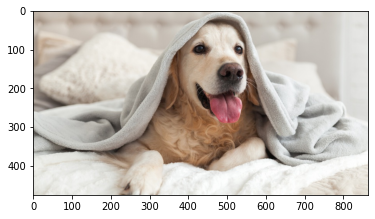

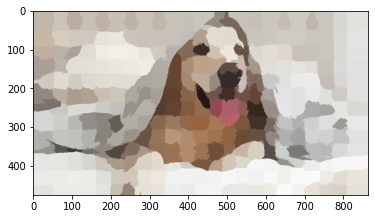

Distance metric as follows:
where m = 'compactness' parameter, and S is a grid spacing parameter for the initial locations of cluster centers.

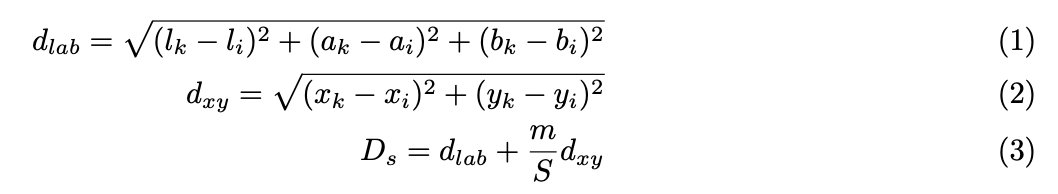

In [2]:
class SLIC:
    
    def __init__(self, imPath_, K_, M_, maxIters_ = 5):
        '''
        SLIC (simple linear iterative clustering) class implements clustering routine based on both color 
        coordinate and positional coordinate distances.
        
        Distance metric is defined as follows:
        d_lab = euclidean distance in lab color space
        d_xy = euclidean distance in positional space
        distance = d_lab + M/S*d_xy
        
        Performs successive iterations of calls to _assignCluster and _recomputeCenter.
        
        Attributes:
         - im: image in lab color coordinates
         - N: image rows*cols
         - K: number of cluster centers (superpixels)
         - M: 'compactness' parameter (how circular are superpixels)
         - S: grid size to produce K equally spaced initial cluster centers
         - centers: current clustering iteration
         - iter: current iteration in clustering routine
         - maxIters: number of clustering iterations to perform
         - distances: array of size (image rows*cols) containing distance from assigned cluster for each
            postion in the image (x, y)
         - im5D: array of size (image rows*cols*5) with lab color coordinates and x,y positional coordinates
         - clusterAssignments: array of size (image rows*cols*5) containing assigned cluster center for each 
            position in the image (x, y)
        '''
        
        self.im = color.rgb2lab(imread(imPath)) # image in lab coordinates
        self.imrows = self.im.shape[0]
        self.imcols = self.im.shape[1]
        self.N = self.imrows*self.imcols
        self.K = K_ 
        self.M = M_ 
        self.S = int(np.sqrt(self.N/K_))
        self.centers = [] 
        self.iter = 0 
        self.maxIters = maxIters_ 
        self.distances = np.ones((self.imrows, self.imcols))*100000 
        self.im5D = np.zeros((self.imrows, self.imcols, 5)) 
        self.clusterAssignments = np.zeros((self.imrows, self.imcols, 5)) # This is superpixel image.
        
        # Fill in 5D array [l, a, b, x, y] (3 color coordinates, 2 positional coordinates):
        x, y = np.meshgrid(range(self.imrows), range(self.imcols), indexing = 'ij')
        self.im5D = np.concatenate([self.im, np.expand_dims(x, axis = 2), np.expand_dims(y, axis = 2)],
                                   axis = 2)
        
        # Initialize K super-pixel centers:
        self.centers = copy.deepcopy(self.im5D[self.S:self.imrows:self.S, self.S:self.imcols:self.S, :])\
                                         .reshape(-1, 5).tolist()

        
    def _assignCluster(self):
        '''
        Purpose: Assign each x,y position in the image to a cluster center.
        
        For each cluster center, consider all image positions (x, y) within a window of 2S on either side of 
        the cluster center position in x and y directions.  
        
        If, for a given image position (x, y) within the window, the distance to the current cluster center is 
        less than the distance to the previously assigned cluster center, assign the image position to the 
        current cluster center.
        
        Distance is combination of euclidean color distance (lab) and euclidean positional distance (xy) as
        described above.
        '''
                
        for idx, curCenter in enumerate(self.centers):
                        
            # Slice 2Sx2S image window centered on x,y; rightmost and bottommost windows get truncated:
            x, y = curCenter[-2], curCenter[-1]
            xMin, xMax = int(x - self.S), int(x + self.S)
            yMin, yMax = int(y - self.S), int(y + self.S)
            points = self.im5D[xMin:xMax, yMin:yMax, :] 
            
            # Calculate distance from center for each point in 2Sx2S window:
            dxy = np.linalg.norm(points[:, :, -2:] - curCenter[-2:], axis = 2)
            dlab = np.linalg.norm(points[:, :, :3] - curCenter[:3], axis = 2)
            distances = dlab + (self.M/self.S)*dxy
            
            # Copy slices of distances and clusterAssignments array for comparison:
            prevDistSlice = copy.deepcopy(self.distances[xMin:xMax, yMin:yMax])
            
            prevCentSlice = copy.deepcopy(self.clusterAssignments[xMin:xMax, yMin:yMax, :])
            
            # Update distance to assigned cluster center for each point in window (if reassigned):
            self.distances[xMin:xMax, yMin:yMax] = np.where(distances < prevDistSlice, distances, prevDistSlice)

            # Update assigned cluster center for each point in window (if reassigned):
            distancesStack = np.concatenate([np.expand_dims(distances, axis = 2)]*5, axis = 2)
            prevDistStack = np.concatenate([np.expand_dims(prevDistSlice, axis = 2)]*5, axis = 2)
            self.clusterAssignments[xMin:xMax, yMin:yMax, :] =\
                                             np.where(distancesStack < prevDistStack, curCenter, prevCentSlice)
                        
    def _recomputeCenter(self):
        '''
        Purpose: Recompute cluster centers as mean of assigned image positions.
        
        For each cluster center, take the mean of the coordinates at image positions assigned to that cluster.
        
        This mean becomes the new cluster center.
        '''
        
        # Collect current list of centers (can't use self.centers as centers may disapper with no assigned
        # image positions).
        currentCenters = np.unique(self.clusterAssignments.reshape(-1, 5), axis = 0).tolist()
        
        newCenters = []
        newClusterAssignments = np.zeros(self.im5D.shape)
        for curCenter in currentCenters:
            
            # Collect image positions assigned to current center and take mean to calculate new center:
            centerPoints = np.where(self.clusterAssignments == curCenter, 
                                    self.im5D, np.ones(self.im5D.shape)*np.nan)
            newCenter = np.nanmean(centerPoints, axis = (0, 1)).astype(np.float32)
            newCenters.append(newCenter)
            
            # Build array of new cluster assignments that reflect updated cluster centers:
            condMatrix = copy.deepcopy(np.all(self.clusterAssignments == curCenter, axis = 2))
            condMatrixStack = np.concatenate([np.expand_dims(condMatrix, axis = 2)]*5, axis = 2)
            newClusterAssignments +=  np.where(condMatrixStack, newCenter, np.zeros(self.im5D.shape))\
                                        .astype(np.float32) 
    
        # Update attributes with new assignments and centers:
        self.clusterAssignments = newClusterAssignments
        self.centers = newCenters

    def iterate(self):
        '''
        Purpose: Alternate _assignCluster and _recomputeCenter calls for maxIters iterations and display
        output image.
        '''
        for idx in range(self.maxIters):
            self._assignCluster()
            self._recomputeCenter()
            self.iter += 1
        
        plt.clf()
        plt.imshow(color.lab2rgb(self.clusterAssignments[:, :, :3]))
        plt.show()
        

### Test Cases:

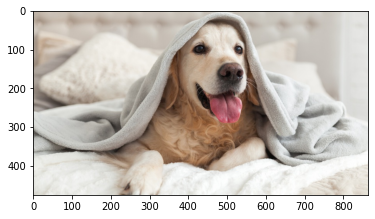

---Baseline: 

K = 300, M = 40: 


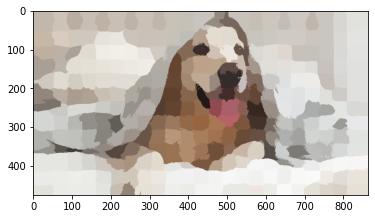

---Effect of M: 

K = 300, M = 10: 


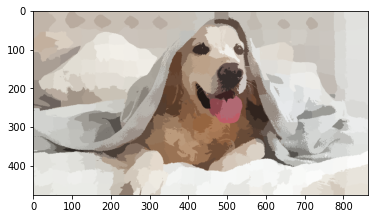

K = 300, M = 100: 


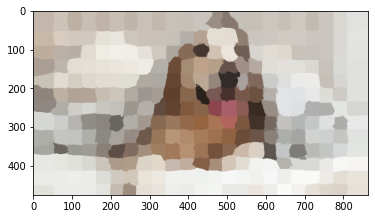

---Effect of K: 

K = 100, M = 40: 


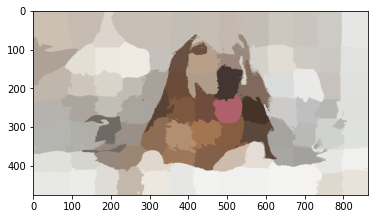

K = 500, M = 40: 


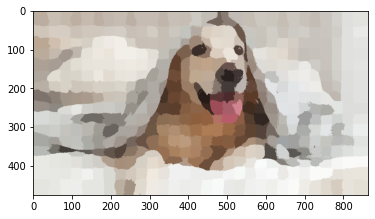

-------------------------------------
-------------------------------------


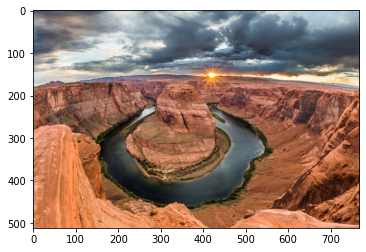

---Baseline: 

K = 300, M = 40: 


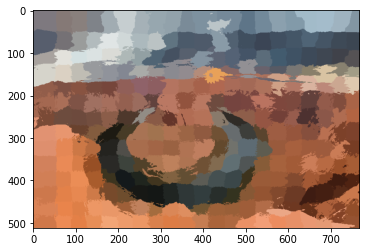

---Effect of M: 

K = 300, M = 10: 


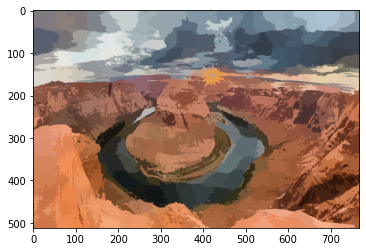

K = 300, M = 100: 


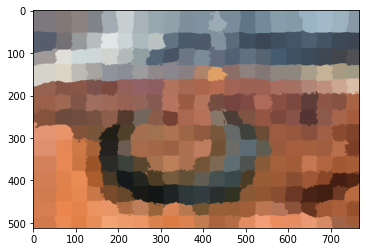

---Effect of K: 

K = 100, M = 40: 


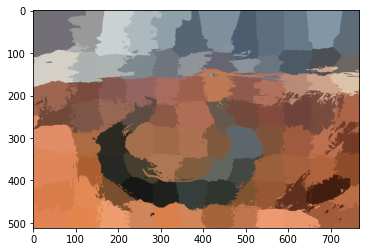

K = 500, M = 40: 


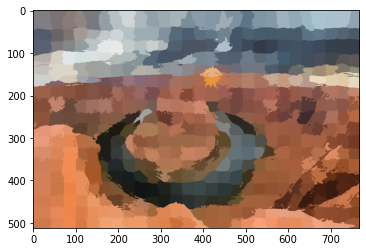

In [3]:
if __name__ == '__main__':
    
    # Test Case 1:
    imPath = 'data/pets.jpg'
    
    plt.clf()
    plt.imshow(imread(imPath))
    plt.show()
    
    print('---Baseline: \n')
    print('K = 300, M = 40: ')
    p = SLIC(imPath, K_=300, M_=40)
    p.iterate()
    
    print('---Effect of M: \n')
    print('K = 300, M = 10: ')
    p = SLIC(imPath, K_=300, M_=10)
    p.iterate()
    
    print('K = 300, M = 100: ')
    p = SLIC(imPath, K_=300, M_=100)
    p.iterate()
    
    print('---Effect of K: \n')
    print('K = 100, M = 40: ')
    p = SLIC(imPath, K_=100, M_=40)
    p.iterate()
    
    print('K = 500, M = 40: ') 
    p = SLIC(imPath, K_=500, M_=40)
    p.iterate()
    
    print('-------------------------------------')
    print('-------------------------------------')
    
    # Test Case 2:
    imPath = 'data/grand_canyon.jpeg'
    
    plt.clf()
    plt.imshow(imread(imPath))
    plt.show()
    
    print('---Baseline: \n')
    print('K = 300, M = 40: ')
    p = SLIC(imPath, K_=300, M_=40)
    p.iterate()
    
    print('---Effect of M: \n')
    print('K = 300, M = 10: ')
    p = SLIC(imPath, K_=300, M_=10)
    p.iterate()
    
    print('K = 300, M = 100: ')
    p = SLIC(imPath, K_=300, M_=100)
    p.iterate()
    
    print('---Effect of K: \n')
    print('K = 100, M = 40: ')
    p = SLIC(imPath, K_=100, M_=40)
    p.iterate()
    
    print('K = 500, M = 40: ') 
    p = SLIC(imPath, K_=500, M_=40)
    p.iterate()